# Quantium Data Analytics Project

# Section 1

## Import packages and read datafiles 

In [458]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime
import xlrd

from collections import Counter

from scipy.stats import ttest_ind

from apyori import apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [224]:
customer = pd.read_csv('QVI_purchase_behaviour.csv')
transaction = pd.read_excel('QVI_transaction_data.xlsx')

## Exploratory Data Analysis

### Data Preprocessing

In [225]:
customer = customer.dropna()
transaction = transaction.dropna()

### Examine transaction data

#### Convert Excel Date into Python Date

In [255]:
transaction['DATE'] = transaction['DATE'].apply(lambda s: xlrd.xldate.xldate_as_datetime(s, 0))
transaction

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural Chip Compny SeaSalt175g
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,CCs Nacho Cheese 175g
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths Crinkle Cut Chips Chicken 170g
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,Smiths Chip Thinly SCreamOnion 175g
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,Kettle Tortilla ChpsHnyJlpno Chili 150g
...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,Kettle Sweet Chilli And Sour Cream 175g
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,Tostitos Splash Of Lime 175g
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,Doritos Mexicana 170g
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,Doritos Corn Chip Mexican Jalapeno 150g


#### Discover the most common words in product names

In [256]:
# Remove special characters in product names

import re

product = transaction['PROD_NAME']

cleaned_name = []
for string in product:
    string = re.sub(r'\\.','', string)       # Remove all \n \t etc..
    string = re.sub(r'[^\w\s]*','', string)  # Remove anything not a digit, letter, or space
    
    cleaned_name.append(string)

transaction['PROD_NAME2'] = cleaned_name

In [257]:
unique_products = []
for p in transaction['PROD_NAME2']:
    if p not in unique_products:
        unique_products.append(p)

In [258]:
# Count the most common words in all product names
count_lists = []

for w in unique_products:
    word = w.split()[:-1]
    count_lists.append(word)


counter = Counter(count_lists[0])
for i in count_lists[1:]: 
    counter.update(i)

counter.most_common(10)

[('Chips', 21),
 ('Smiths', 16),
 ('Crinkle', 14),
 ('Cut', 14),
 ('Kettle', 13),
 ('Cheese', 12),
 ('Salt', 11),
 ('Original', 10),
 ('Chip', 9),
 ('Salsa', 9)]

#### Check for outliers

In [259]:
sort_by_quant1 = transaction.sort_values('PROD_QTY',ascending=False)
sort_by_quant1.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,Dorito Corn Chp Supreme 380g
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,Dorito Corn Chp Supreme 380g
217237,2019-05-18,201,201060,200202,26,Pringles Sweet&Spcy BBQ 134g,5,18.5,Pringles SweetSpcy BBQ 134g
238333,2018-08-14,219,219004,218018,25,Pringles SourCream Onion 134g,5,18.5,Pringles SourCream Onion 134g
238471,2019-05-19,261,261331,261111,87,Infuzions BBQ Rib Prawn Crackers 110g,5,19.0,Infuzions BBQ Rib Prawn Crackers 110g


In [260]:
# There are two transactions where 200 packets of chips are bought in one transaction 
# and both of these transactions were by the same customer.

# It looks like this customer has only had the two transactions over the year 
# and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. 
# We'll remove this loyalty card number from further analysis.![image.png]


#### Filtering out outliers

In [261]:
i = transaction.loc[transaction['PROD_QTY']>50].index
transaction_new = transaction.drop(i)
transaction_new.head()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural Chip Compny SeaSalt175g
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,CCs Nacho Cheese 175g
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths Crinkle Cut Chips Chicken 170g
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,Smiths Chip Thinly SCreamOnion 175g
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,Kettle Tortilla ChpsHnyJlpno Chili 150g


In [262]:
sort_by_quant2 = transaction_new.sort_values('PROD_QTY',ascending=False)
sort_by_quant2.head()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2
5415,2018-08-20,236,236116,239252,12,Natural Chip Co Tmato Hrb&Spce 175g,5,15.0,Natural Chip Co Tmato HrbSpce 175g
32796,2019-05-18,236,236033,238735,59,Old El Paso Salsa Dip Tomato Med 300g,5,25.5,Old El Paso Salsa Dip Tomato Med 300g
5107,2018-08-17,54,54225,48172,46,Kettle Original 175g,5,27.0,Kettle Original 175g
80732,2019-05-18,49,49309,45816,30,Doritos Corn Chips Cheese Supreme 170g,5,22.0,Doritos Corn Chips Cheese Supreme 170g
32762,2018-08-19,227,227046,228561,100,Smiths Crinkle Cut Chips Chs&Onion170g,5,14.5,Smiths Crinkle Cut Chips ChsOnion170g


#### Select only the "chips" products to evaluate

In [263]:
j = transaction.loc[transaction['PROD_NAME'].str.contains("Chips", na=False)].index
chips = transaction.iloc[j]
chips.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths Crinkle Cut Chips Chicken 170g
6,2019-05-16,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7,Smiths Crinkle Chips Salt Vinegar 330g
10,2019-05-17,7,7215,7176,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7,Smiths Crinkle Chips Salt Vinegar 330g
14,2019-05-15,19,19272,16686,44,Thins Chips Light& Tangy 175g,1,3.3,Thins Chips Light Tangy 175g
33,2019-05-18,45,45220,41651,22,Thins Chips Originl saltd 175g,1,3.3,Thins Chips Originl saltd 175g


#### Count number of transactions by date

In [264]:
transQuant = chips.groupby('DATE').sum()[['PROD_QTY','TOT_SALES']]
transQuant
# There's only 364 rows, meaning only 364 dates which indicates a missing date. 
# Let's create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
# chart of number of transactions over time to find the missing date.


,PROD_QTY,TOT_SALES
DATE,,
2018-07-01,230,787.9
2018-07-02,250,905.6
2018-07-03,262,912.9
2018-07-04,227,758.2
2018-07-05,254,876.6
...,...,...
2019-06-26,241,860.3
2019-06-27,242,831.8
2019-06-28,307,1074.9


In [265]:
transCount = chips.groupby('DATE').count()['PROD_QTY']
transCount

DATE
2018-07-01    121
2018-07-02    129
2018-07-03    136
2018-07-04    119
2018-07-05    134
             ... 
2019-06-26    127
2019-06-27    127
2019-06-28    159
2019-06-29    139
2019-06-30    149
Name: PROD_QTY, Length: 364, dtype: int64

In [266]:
trans_all = pd.merge(transQuant,transCount, on = 'DATE')
trans_all.rename(columns={'PROD_QTY_y': 'TRANS_COUNT'}, inplace=True)
trans_all

,PROD_QTY_x,TOT_SALES,TRANS_COUNT
DATE,,,
2018-07-01,230,787.9,121
2018-07-02,250,905.6,129
2018-07-03,262,912.9,136
2018-07-04,227,758.2,119
2018-07-05,254,876.6,134
...,...,...,...
2019-06-26,241,860.3,127
2019-06-27,242,831.8,127
2019-06-28,307,1074.9,159


#### Create a dataframe of all dates range from 2018-07-01 to 2019-06-30, 
#### and then join it with the count of transactions by date

In [267]:
alldates = pd.DataFrame(pd.date_range(start="2018-07-01",end="2019-06-30"), columns=['DATE'])
alldates

,DATE
0,2018-07-01
1,2018-07-02
2,2018-07-03
3,2018-07-04
4,2018-07-05
...,...
360,2019-06-26
361,2019-06-27
362,2019-06-28
363,2019-06-29


In [268]:
transdates = pd.merge(alldates, trans_all, on='DATE', how = 'left')
#transdates['PROD_QTY'] = transdates['PROD_QTY'].fillna(0)
transdates = transdates.fillna(0)
transdates

,DATE,PROD_QTY_x,TOT_SALES,TRANS_COUNT
0,2018-07-01,230.0,787.9,121.0
1,2018-07-02,250.0,905.6,129.0
2,2018-07-03,262.0,912.9,136.0
3,2018-07-04,227.0,758.2,119.0
4,2018-07-05,254.0,876.6,134.0
...,...,...,...,...
360,2019-06-26,241.0,860.3,127.0
361,2019-06-27,242.0,831.8,127.0
362,2019-06-28,307.0,1074.9,159.0
363,2019-06-29,264.0,933.3,139.0


#### Identify the date that doesn't have any transactions

In [269]:
zero = transdates.loc[transdates['TOT_SALES']==0]
zero

,DATE,PROD_QTY_x,TOT_SALES,TRANS_COUNT
177,2018-12-25,0.0,0.0,0.0


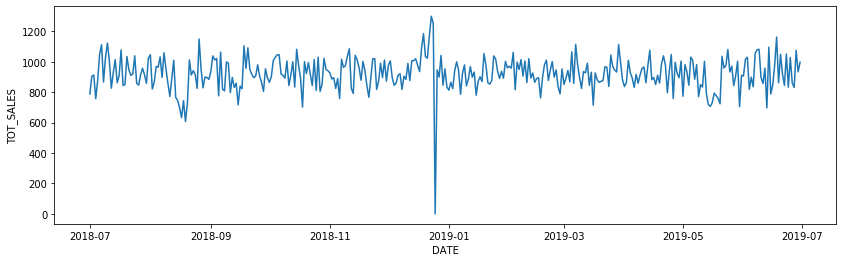

In [270]:
plt.figure(figsize=(14,4))

sns.lineplot(x='DATE',y='TOT_SALES',data=transdates)


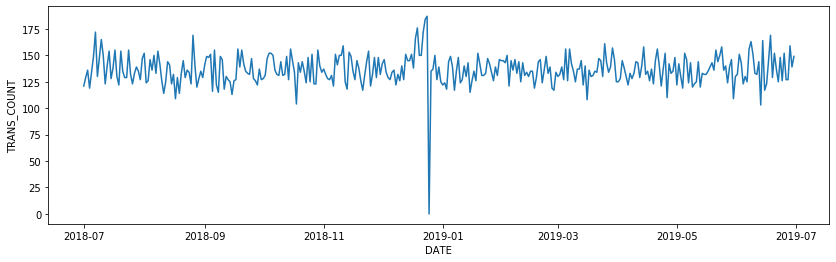

In [271]:
plt.figure(figsize=(14,4))
sns.lineplot(x='DATE',y='TRANS_COUNT',data=transdates)

In [272]:
# We can see that the increase in sales occurs in the lead-up to Christmas and that
# there are zero sales on Christmas day itself. This is due to shops being closed on
# Christmas day.


### Create another feature - Package Size

In [273]:
transaction_new['PACK_SIZE'] = transaction_new['PROD_NAME'].str.extract('(\d+)')
transaction_new['PACK_SIZE'] = transaction_new['PACK_SIZE'].astype(int)


In [274]:
transaction_new['PACK_SIZE'].max()   # Maximum: 380
transaction_new['PACK_SIZE'].min()   # Minimum: 70

70

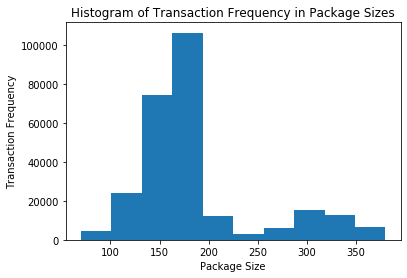

In [275]:
hist = plt.hist(transaction_new['PACK_SIZE'])
hist = plt.xlabel('Package Size') 
hist = plt.ylabel('Transaction Frequency') 
hist = plt.title('Histogram of Transaction Frequency in Package Sizes')

### Create another feature - Brand

In [276]:
brandlist = []
for b in transaction_new['PROD_NAME']:
    brand = b.split()[0]
    brandlist.append(brand.upper())
transaction_new['BRAND'] = brandlist
transaction_new.head(40)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural Chip Compny SeaSalt175g,175,NATURAL
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,CCs Nacho Cheese 175g,175,CCS
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths Crinkle Cut Chips Chicken 170g,170,SMITHS
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,Smiths Chip Thinly SCreamOnion 175g,175,SMITHS
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,Kettle Tortilla ChpsHnyJlpno Chili 150g,150,KETTLE
5,2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1,Old El Paso Salsa Dip Tomato Mild 300g,300,OLD
6,2019-05-16,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7,Smiths Crinkle Chips Salt Vinegar 330g,330,SMITHS
7,2019-05-16,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6,Grain Waves Sweet Chilli 210g,210,GRAIN
8,2018-08-20,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9,Doritos Corn Chip Mexican Jalapeno 150g,150,DORITOS
9,2018-08-18,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2,Grain Waves Sour CreamChives 210G,210,GRAIN


In [277]:
transaction_new['BRAND'] = transaction_new['BRAND'].replace('RED','RDD')
transaction_new['BRAND'] = transaction_new['BRAND'].replace('"SNBTS','SUNBITES')
transaction_new['BRAND'] = transaction_new['BRAND'].replace('INFZNS','INFUZIONS')
transaction_new['BRAND'] = transaction_new['BRAND'].replace('WW','WOOLWORTHS')
transaction_new['BRAND'] = transaction_new['BRAND'].replace('SMITH','SMITHS')
transaction_new['BRAND'] = transaction_new['BRAND'].replace('NCC','NATURAL')
transaction_new['BRAND'] = transaction_new['BRAND'].replace('DORITO','DORITOS')
transaction_new['BRAND'] = transaction_new['BRAND'].replace('GRAIN','GRNWVES')

In [278]:
transaction_new.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural Chip Compny SeaSalt175g,175,NATURAL
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,CCs Nacho Cheese 175g,175,CCS
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths Crinkle Cut Chips Chicken 170g,170,SMITHS
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,Smiths Chip Thinly SCreamOnion 175g,175,SMITHS
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,Kettle Tortilla ChpsHnyJlpno Chili 150g,150,KETTLE


### Examine customer data

In [432]:
customer.groupby('LIFESTAGE').count().sort_values('LYLTY_CARD_NBR', ascending = False)


,LYLTY_CARD_NBR,PREMIUM_CUSTOMER
LIFESTAGE,,
RETIREES,14805,14805
OLDER SINGLES/COUPLES,14609,14609
YOUNG SINGLES/COUPLES,14441,14441
OLDER FAMILIES,9780,9780
YOUNG FAMILIES,9178,9178
MIDAGE SINGLES/COUPLES,7275,7275
NEW FAMILIES,2549,2549


In [433]:
customer.groupby('PREMIUM_CUSTOMER').count().sort_values('LYLTY_CARD_NBR', ascending = False)

,LYLTY_CARD_NBR,LIFESTAGE
PREMIUM_CUSTOMER,,
Mainstream,29245,29245
Budget,24470,24470
Premium,18922,18922


In [434]:
all_data = pd.merge(customer, transaction_new, on='LYLTY_CARD_NBR', how='inner')
all_data

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2,PACK_SIZE,BRAND
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural Chip Compny SeaSalt175g,175,NATURAL
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,Red Rock Deli ChiknGarlic Aioli 150g,150,RDD
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,Grain Waves Sour CreamChives 210G,210,GRNWVES
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,Natural ChipCo Hony Soy Chckn175g,175,NATURAL
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,WW Original Stacked Chips 160g,160,WOOLWORTHS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,YOUNG FAMILIES,Mainstream,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,Grain Waves Sweet Chilli 210g,210,GRNWVES
264830,2370751,YOUNG FAMILIES,Premium,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,Kettle Tortilla ChpsFetaGarlic 150g,150,KETTLE
264831,2370961,OLDER FAMILIES,Budget,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,Tyrrells Crisps Lightly Salted 165g,165,TYRRELLS
264832,2370961,OLDER FAMILIES,Budget,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,Old El Paso Salsa Dip Chnky Tom Ht300g,300,OLD


In [435]:
Tot_by_customer = all_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).sum()[['PROD_QTY','TOT_SALES']].sort_values('TOT_SALES',ascending=False)
Tot_by_customer.head()

,,PROD_QTY,TOT_SALES
LIFESTAGE,PREMIUM_CUSTOMER,,
OLDER FAMILIES,Budget,45065,168363.25
YOUNG SINGLES/COUPLES,Mainstream,38632,157621.60
RETIREES,Mainstream,40518,155677.05
YOUNG FAMILIES,Budget,37111,139345.85
OLDER SINGLES/COUPLES,Budget,35220,136769.80


In [436]:
# Sales are coming mainly from Budget - older families, 
#                              Mainstream - youngsingles/couples, 
#                          and Mainstream - retirees


In [497]:
Tot_by_Lifestage = all_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).sum()['TOT_SALES']
Tot_by_Lifestage

LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget               35514.80
                        Mainstream           90803.85
                        Premium              58432.65
NEW FAMILIES            Budget               21928.45
                        Mainstream           17013.90
                        Premium              11491.10
OLDER FAMILIES          Budget              168363.25
                        Mainstream          103445.55
                        Premium              80658.40
OLDER SINGLES/COUPLES   Budget              136769.80
                        Mainstream          133393.80
                        Premium             132263.15
RETIREES                Budget              113147.80
                        Mainstream          155677.05
                        Premium              97646.05
YOUNG FAMILIES          Budget              139345.85
                        Mainstream           92788.75
                        Premium          

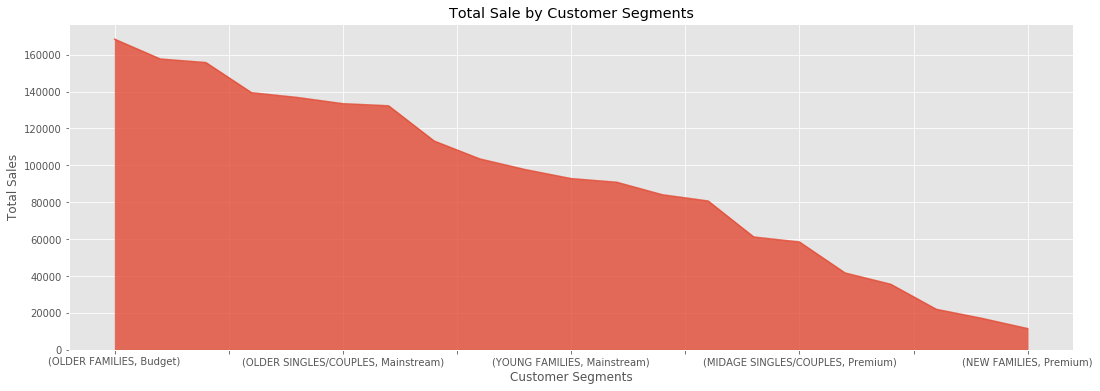

In [438]:
plt.style.use('ggplot')
plt.figure(figsize=(18,6))

Tot = Tot_by_customer['TOT_SALES'].plot.area(alpha=0.8)

Tot = plt.xlabel('Customer Segments') 
Tot = plt.ylabel('Total Sales') 
Tot = plt.title('Total Sale by Customer Segments')


Text(0.5, 1.0, 'Total Sale by LIFESTAGE')

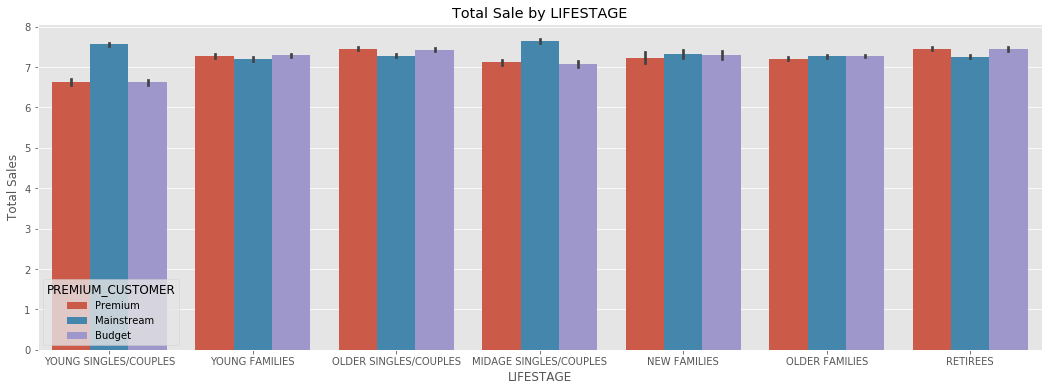

In [439]:
plt.figure(figsize=(18,6))
tot_lifestage = sns.barplot(x='LIFESTAGE',y='TOT_SALES', hue = 'PREMIUM_CUSTOMER', data=all_data)

tot_lifestage.set_xlabel('LIFESTAGE') 
tot_lifestage.set_ylabel('Total Sales') 
tot_lifestage.set_title('Total Sale by LIFESTAGE')

In [441]:
all_data['AVG_UNIT'] = all_data['PROD_QTY']/all_data['LYLTY_CARD_NBR']


In [442]:
sum_qt = all_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).sum()['PROD_QTY']

In [443]:
nunique = all_data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).nunique()['LYLTY_CARD_NBR']

In [452]:
combine = pd.merge(sum_qt,nunique, on=('LIFESTAGE','PREMIUM_CUSTOMER'))
combine['AVG_UNIT'] = combine['PROD_QTY']/combine['LYLTY_CARD_NBR']
combine.reset_index(inplace=True)
combine.head()

,LIFESTAGE,PREMIUM_CUSTOMER,PROD_QTY,LYLTY_CARD_NBR,AVG_UNIT
0,MIDAGE SINGLES/COUPLES,Budget,9496,1504,6.313830
1,MIDAGE SINGLES/COUPLES,Mainstream,22699,3340,6.796108
2,MIDAGE SINGLES/COUPLES,Premium,15526,2431,6.386672
3,NEW FAMILIES,Budget,5571,1112,5.009892
4,NEW FAMILIES,Mainstream,4319,849,5.087161


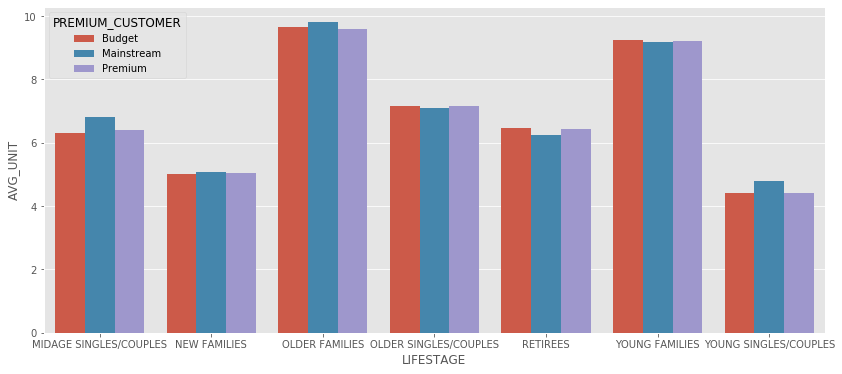

In [451]:
plt.figure(figsize=(14,6))
sns.barplot( x = 'LIFESTAGE', y = 'AVG_UNIT', hue='PREMIUM_CUSTOMER', data = combine)
tot_lifestage.set_title('Average Unit by LIFESTAGE')

In [453]:
Avg_Price_per_Unit = Tot_by_customer['TOT_SALES']/Tot_by_customer['PROD_QTY']
Avg_Price_per_Unit.sort_values(ascending = False)

LIFESTAGE               PREMIUM_CUSTOMER
YOUNG SINGLES/COUPLES   Mainstream          4.080079
MIDAGE SINGLES/COUPLES  Mainstream          4.000346
NEW FAMILIES            Mainstream          3.939315
                        Budget              3.936178
RETIREES                Budget              3.933660
                        Premium             3.924050
OLDER SINGLES/COUPLES   Premium             3.891695
NEW FAMILIES            Premium             3.886067
OLDER SINGLES/COUPLES   Budget              3.883299
RETIREES                Mainstream          3.842170
OLDER SINGLES/COUPLES   Mainstream          3.811578
MIDAGE SINGLES/COUPLES  Premium             3.763535
YOUNG FAMILIES          Budget              3.754840
                        Premium             3.750134
MIDAGE SINGLES/COUPLES  Budget              3.739975
OLDER FAMILIES          Budget              3.736009
                        Mainstream          3.726962
YOUNG FAMILIES          Mainstream          3.705029
OLDER

Text(0.5, 1.0, 'Average Price by LIFESTAGE')

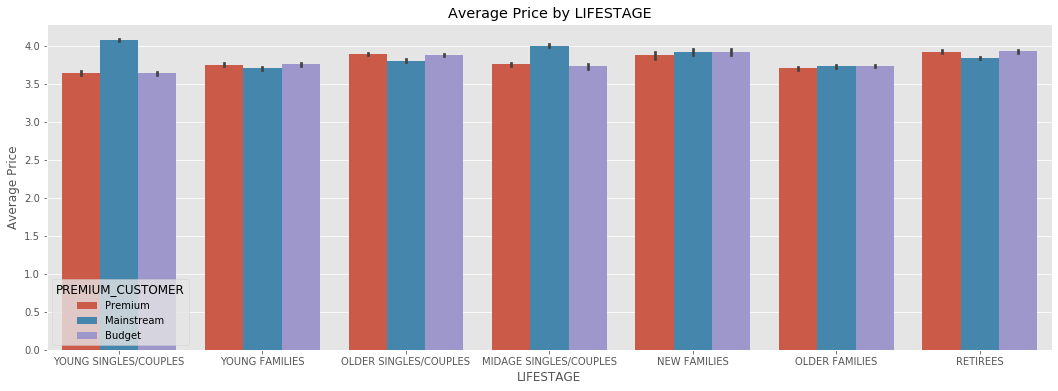

In [454]:
plt.figure(figsize=(18,6))
avgPrice_lifestage = sns.barplot(x='LIFESTAGE', y = all_data['TOT_SALES']/all_data['PROD_QTY'] , hue = 'PREMIUM_CUSTOMER', data=all_data)

avgPrice_lifestage .set_xlabel('LIFESTAGE') 
avgPrice_lifestage .set_ylabel('Average Price') 
avgPrice_lifestage .set_title('Average Price by LIFESTAGE')

In [455]:
main = [Avg_Price_per_Unit['YOUNG SINGLES/COUPLES']['Mainstream'],Avg_Price_per_Unit['MIDAGE SINGLES/COUPLES']['Mainstream']]
others = [Avg_Price_per_Unit['YOUNG SINGLES/COUPLES']['Budget'],Avg_Price_per_Unit['YOUNG SINGLES/COUPLES']['Premium'],Avg_Price_per_Unit['MIDAGE SINGLES/COUPLES']['Budget'],Avg_Price_per_Unit['MIDAGE SINGLES/COUPLES']['Premium']]

In [456]:
ttest_ind(main, others)

Ttest_indResult(statistic=7.6068869237118735, pvalue=0.0016027797701074072)

In [473]:
# The t-test results in a p-value of 0.0016, 
# the unit price for mainstream, young and mid-age singles and couples are significantly higher than
# that of budget or premium, young and midage singles and couples.

### Implementing Apriori algorithm

In [518]:
#from apyori import apriori
#from mlxtend.frequent_patterns import apriori
#from mlxtend.frequent_patterns import association_rules

#### Uncover associations in Brand

In [522]:
df = all_data
df_young_main = df[(df['LIFESTAGE']=='YOUNG SINGLES/COUPLES') & (df['PREMIUM_CUSTOMER']=='Mainstream')]
df_young_main

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_NAME2,PACK_SIZE,BRAND,AVG_UNIT
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,Red Rock Deli ChiknGarlic Aioli 150g,150,RDD,9.980040e-04
9,1010,YOUNG SINGLES/COUPLES,Mainstream,2018-09-09,1,10,51,Doritos Mexicana 170g,2,8.8,Doritos Mexicana 170g,170,DORITOS,1.980198e-03
10,1010,YOUNG SINGLES/COUPLES,Mainstream,2018-12-14,1,11,59,Old El Paso Salsa Dip Tomato Med 300g,1,5.1,Old El Paso Salsa Dip Tomato Med 300g,300,OLD,9.900990e-04
21,1018,YOUNG SINGLES/COUPLES,Mainstream,2018-09-03,1,22,3,Kettle Sensations Camembert & Fig 150g,1,4.6,Kettle Sensations Camembert Fig 150g,150,KETTLE,9.823183e-04
22,1018,YOUNG SINGLES/COUPLES,Mainstream,2018-11-28,1,23,97,RRD Salt & Vinegar 165g,1,3.0,RRD Salt Vinegar 165g,165,RRD,9.823183e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264785,272391,YOUNG SINGLES/COUPLES,Mainstream,2018-12-07,272,270205,63,Kettle 135g Swt Pot Sea Salt,2,8.4,Kettle 135g Swt Pot Sea Salt,135,KETTLE,7.342386e-06
264805,2330041,YOUNG SINGLES/COUPLES,Mainstream,2018-09-23,77,236718,24,Grain Waves Sweet Chilli 210g,2,7.2,Grain Waves Sweet Chilli 210g,210,GRNWVES,8.583540e-07
264818,2330321,YOUNG SINGLES/COUPLES,Mainstream,2018-07-30,77,236756,71,Twisties Cheese Burger 250g,2,8.6,Twisties Cheese Burger 250g,250,TWISTIES,8.582509e-07
264824,2370181,YOUNG SINGLES/COUPLES,Mainstream,2018-08-02,88,240146,36,Kettle Chilli 175g,2,10.8,Kettle Chilli 175g,175,KETTLE,8.438174e-07


In [523]:
basket1 = df_young_main.pivot_table('PROD_QTY',['LYLTY_CARD_NBR'],'BRAND').fillna(0)

In [524]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets_1 = basket1.applymap(encode_units)
basket_sets_1

BRAND,BURGER,CCS,CHEETOS,CHEEZELS,COBS,DORITOS,FRENCH,GRNWVES,INFUZIONS,KETTLE,...,RDD,RRD,SMITHS,SNBTS,SUNBITES,THINS,TOSTITOS,TWISTIES,TYRRELLS,WOOLWORTHS
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1010,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1018,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1060,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272391,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2330041,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2330321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [525]:
frequent_itemsets_young = apriori(basket_sets_1, min_support=0.07, use_colnames=True)
frequent_itemsets_young.sort_values('support', ascending = False).head()

,support,itemsets
4,0.378956,(KETTLE)
1,0.267928,(DORITOS)
6,0.250742,(PRINGLES)
8,0.203759,(SMITHS)
3,0.140084,(INFUZIONS)


In [492]:
# The 'YOUNG SINGLES/COUPLES' & 'Mainstream' segment tend to favor the following brands in descending order:
# - Kettle
# - Doritos
# - Pringles
# - Smiths
# - INFUZIONS

In [554]:
#rules_young = association_rules(frequent_itemsets_young, metric="lift", min_threshold=1)    --> (minsupport = 0.045)
#rules_young.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Smiths),(Doritos),0.193744,0.238872,0.047725,0.246331,1.031222,0.001445,1.009896
1,(Doritos),(Smiths),0.238872,0.193744,0.047725,0.199793,1.031222,0.001445,1.007559


In [543]:
'''
Explanation of the output:

The output shows the support and confidence values for (B, A) and (A, B) as well. It means some people may buy B and then A and some people first buy A and then buys B. For such transactions confidence, lift and leverage is calculated.

A high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. (Lift is confidence/support)

'''

'\nExplanation of the output:\n\nThe output shows the support and confidence values for (B, A) and (A, B) as well. It means some people may buy B and then A and some people first buy A and then buys B. For such transactions confidence, lift and leverage is calculated.\n\nA high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. (Lift is confidence/support)\n\n'

#### Uncover associations in Package Size

In [493]:
basket_2 = df_young_main.pivot_table('PROD_QTY',['LYLTY_CARD_NBR'],'PACK_SIZE').fillna(0)

In [494]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets_2 = basket_2.applymap(encode_units)
basket_sets_2

PACK_SIZE,70,90,110,125,134,135,150,160,165,170,...,180,190,200,210,220,250,270,300,330,380
LYLTY_CARD_NBR,,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1010,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1018,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1020,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1060,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272391,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2330041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2330321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [496]:
frequent_itemsets_2 = apriori(basket_sets_2, min_support=0.07, use_colnames=True)
frequent_itemsets_2.sort_values('support', ascending = False).head()

,support,itemsets
5,0.448566,(175)
2,0.318867,(150)
1,0.250742,(134)
0,0.219708,(110)
4,0.173096,(170)


In [ ]:
# The 'YOUNG SINGLES/COUPLES' & 'Mainstream' segment tend to favor the following pakage sizes in descending order:
# - 175g
# - 150g
# - 134g

## Conclusion

### Sales have mainly generated through :
####     Budget - older families, Mainstream - young singles/couples, and Mainstream retirees shoppers. 


### We found a trends of :
####    - High spend in chips for mainstream young singles/couples and retirees, due to there being more of them than other buyers

####    - Mainstream, midage and young singles and couples are more likely to pay more per packet of chips

####    - The Mainstream young singles and couples are 38% more likely to purchase Kettle chips compared to the rest of the population 
####      (The Category Manager may want to increase the category’s performance by off-locating some Kettle and smaller packs of chips 
####       in discretionary space near segments where young singles and couples frequent more often to increase visibilty and impulse behaviour.)